In [ ]:
!git config --global user.name "Belaleatsbanana"
!git config --global user.email "belalofficial123@gmail.com"

In [ ]:
# Clone the repository
!git clone https://github.com/Belaleatsbanana/ml2.git
%cd ml2

In [ ]:
%pip install -r requirements.txt

# Dataset Description: Dou Shou Qi (Jungle Chess)

## Game Overview
**Dou Shou Qi** ("Game of Fighting Animals") is a Chinese board game also known as:
- Jungle Chess


## Game Characteristics
- **Type**: Two-player abstract strategy game
- **Origins**: Evolved around the 1900s in China
- **Similar to**: Chess, Stratego, and other Chinese Chess-like games (e.g., Banqi)
- **First described by**: Pritchard and Beasley (2007)

## Board Layout
- **Dimensions**: 9 × 7 rectangular board (63 squares)
- **Files (columns)**: Labeled a–g (left to right)
- **Ranks (rows)**: Numbered 1–9 (bottom to top, from white player's perspective)

## Game Pieces
Each player has 8 pieces representing animals with different strengths:
- **Strength 7**: Elephant (strongest)
- **Strength 6**: Lion
- **Strength 5**: Tiger
- **Strength 4**: Leopard
- **Strength 3**: Wolf (Dog)
- **Strength 2**: Cat
- **Strength 1**: Rat (Mouse)
- **Strength 0**: Den (goal position)

## Special Board Features
- **Dens**: Each player's home square (must be defended)
- **Traps**: Squares that weaken pieces
- **Water/Rivers**: Special squares that only Rats can enter

## Dataset Purpose
This dataset contains game states from Dou Shou Qi matches, where:
- **Features**: Board positions, piece locations, distances to dens, tactical positions
- **Target**: Game outcome (winner: 'w' for white, 'b' for black)
- **Application**: Predict game outcomes from board states for strategic analysis

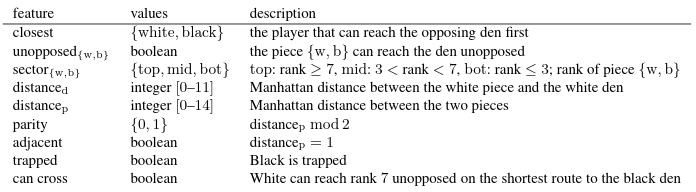


---

## Statistical Insights from Dataset (5,880 game states)

### Piece Distribution
- **Strength Balance**: Both white and black pieces have identical mean strength of 3.5, indicating perfectly balanced dataset
- **Strength Range**: Pieces range from 0 (Den) to 7 (Elephant), with equal distribution across all strength levels
- **Position Spread**: Files average 3.0 (center of a-g board) and ranks average 4.0 (middle of 9 rows), showing pieces are well-distributed across the board

### Distance Metrics
- **Den Distances**: Both white and black pieces average ~5.8 moves to either den (min: 1, max: 11)
- **Tactical Positioning**: The median distance to dens is 6 moves, suggesting most game states are in mid-game phase
- **Distance Symmetry**: `closest_to_den_diff` averages 3.25, showing significant positional advantages vary throughout games

### Special Board Features Usage
- **Trap Occupancy**: Only ~5.5% of pieces are in trap squares (rare but strategic)
- **Water Presence**: 10% of pieces are in water (only Rats can occupy these squares)
- **River Crossing Ability**: 
  - White pieces can cross in 75% of states
  - Black pieces can cross in 67% of states
  - Indicates white has slightly better mobility on average

### Tactical Indicators
- **Unopposed to Den**: 
  - White: 56.9% of states have unopposed path to black's den
  - Black: 47.3% of states have unopposed path to white's den
  - **Key Insight**: White appears to have tactical advantage in ~10% more game states

- **Quick Detour Opportunities**:
  - White: 38% can make quick detour to den
  - Black: 27.9% can make quick detour to den
  - Shows white's superior tactical flexibility

- **Bank Control**: 
  - White: 94.6% have unopposed path to river bank
  - Black: 88.4% have unopposed path to river bank
  - White demonstrates better board control

### Position-Specific Features
- **Black at d7**: Only 1.8% of states have black piece at this critical position (likely a defensive/strategic square)
- **Unopposed Path Variability**: 
  - `unopposedto_black_den_length` has high std (2.78), showing paths vary greatly
  - Value of -1 indicates blocked paths (common at 25th percentile)

In [ ]:
# imports
# Data manipulation and exploration
import numpy as np
import pandas as pd
from scipy import stats
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
cmap = "rocket"
colors = ['#3498db', '#e74c3c', '#95a5a6']

# Data preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV

# Handling imbalanced data
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler, SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, EditedNearestNeighbours
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline

# Classification algorithms
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Pipelines
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

# Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, auc, confusion_matrix, classification_report,
    precision_recall_curve, average_precision_score, matthews_corrcoef,
    cohen_kappa_score, log_loss, balanced_accuracy_score, make_scorer
)

# MLflow
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature


RANDOM_SEED = int("GOGU", 36)

# Helper function to display .info() as a DataFrame
def info_df(df):
    """Display DataFrame.info() as a DataFrame for better visualization"""
    info_dict = {
        'Column': df.columns,
        'Non-Null Count': [df[col].count() for col in df.columns],
        'Null Count': [df[col].isna().sum() for col in df.columns],
        'Dtype': [df[col].dtype for col in df.columns],
        'Unique': [df[col].nunique() for col in df.columns]
    }
    info_table = pd.DataFrame(info_dict)
    print(f"Dataset Shape: {df.shape[0]} rows × {df.shape[1]} columns")
    return info_table


In [ ]:
# Load dataset and handle missing values
jungle_dataset = pd.read_csv('bell/rat_elephant_data.csv', na_values=['\\N'])

print(f"Dataset Shape: {jungle_dataset.shape}")
jungle_dataset.head(5)

In [ ]:
# Perform stratified train-test split

X = jungle_dataset.drop('class', axis=1)
y = jungle_dataset['class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=RANDOM_SEED
)

train_data = X_train.copy()
train_data['class'] = y_train

test_data = X_test.copy()
test_data['class'] = y_test

print("\nOriginal:")
print(jungle_dataset['class'].value_counts(normalize=True).sort_index())

print("\nTraining:")
print(train_data['class'].value_counts(normalize=True).sort_index())

print("\nTest:")
print(test_data['class'].value_counts(normalize=True).sort_index())

In [ ]:
# datasets info
info_df(train_data)

In [ ]:
# datasets desc
# Looks insanly better
train_data.describe().T

In [ ]:
# value counts
for col in train_data.columns:
    print(f"Value counts for column '{col}':")
    print(train_data[col].value_counts())
    print("\n")

## Understanding features and their values in the Dataset

### Negative Values (-1)
The value **-1** in "unopposed" path features indicates:
- **`white_piece0_unopposedto_black_den_length = -1`**: White piece does NOT have a clear path to black's den
- **`black_piece0_unopposedto_white_den_length = -1`**: Black piece does NOT have a clear path to white's den

This is a **sentinel value** meaning:
- The path is **blocked** by an opponent's piece
- No clear route exists to the enemy den
- The piece would face opposition trying to reach the goal

When the value is **≥ 0**, it represents the **length of the unopposed path** in squares. (Manhattan Distance)

### Missing Values (\N -> NaN)




### White Piece Features (piece0 = strongest/most important piece)

#### Position Features
- **`white_piece0_strength`**: Piece power level
  - Range: 0-7 (0=Rat, 1=Cat, 2=Dog, 3=Wolf, 4=Leopard, 5=Tiger, 6=Lion, 7=Elephant)
  - Values: `[0, 1, 2, 3, 4, 5, 6, 7]`

- **`white_piece0_file`**: Column position on board
  - Range: 0-6 (represents files a-g)
  - Values: `[0, 1, 2, 3, 4, 5, 6]`

- **`white_piece0_rank`**: Row position on board
  - Range: 0-8 (represents ranks 1-9)
  - Values: `[0, 1, 2, 3, 4, 5, 6, 7, 8]`

- **`white_piece0_advanced`**: Territorial position
  - Values: `['DEF', 'MID', 'ATT']`
  - `DEF` = Defensive third (near own den)
  - `MID` = Middle third (neutral territory)
  - `ATT` = Attacking third (near enemy den)

#### Distance Metrics
- **`white_piece0_distanceto_white_den`**: Manhattan distance to own den
  - Range: 1-11 moves
  - Lower = closer to home/defense

- **`white_piece0_distanceto_black_den`**: Manhattan distance to enemy den
  - Range: 1-11 moves
  - Lower = better attacking position

- **`white_piece0_movesto_white_den`**: Actual moves needed to reach own den
  - Range: 1-11 moves
  - Considers obstacles (water, traps)

- **`white_piece0_movesto_black_den`**: Actual moves needed to reach enemy den
  - Range: 1-11 moves
  - Considers obstacles

#### Path Features
- **`white_piece0_unopposedto_black_den_length`**: Length of clear path to enemy den
  - Values: `-1` = blocked/no clear path, `0-10` = path length in squares
  - Key tactical indicator!

- **`white_piece0_unopposedto_black_den_shortest`**: Is it the shortest unopposed path?
  - Values: `0` = No, `1` = Yes (but always 0 in this dataset)

#### Board Feature Occupancy
- **`white_piece0_in_trap`**: Is piece in a trap square?
  - Values: `0` = No, `1` = Yes
  - Trap squares weaken pieces (vulnerability indicator)

- **`white_piece0_in_water`**: Is piece in water/river?
  - Values: `0` = No, `1` = Yes
  - Only Rats can be in water

#### Mobility Features
- **`white_piece0_can_cross`**: Can piece cross the river?
  - Values: `0` = No, `1` = Yes
  - Lions and Tigers can jump across, Rat can swim

- **`white_piece0_can_cross_shortest`**: Can cross via shortest path?
  - Values: `0` = No, `1` = Yes

- **`white_piece0_unopposed_to_bank`**: Clear path to river bank?
  - Values: `0` = Blocked, `1` = Clear

#### Piece-to-Piece Relationships
- **`white_piece0_distanceto_black_piece0`**: Distance to strongest black piece
  - Range: 1-14 moves (or NaN if undefined)
  - Indicates potential combat engagement

- **`white_piece0_distanceto_black_piece0_parity`**: Distance parity (even/odd)
  - Values: `0` = Even, `1` = Odd, `NaN` = undefined
  - Affects who can initiate combat

- **`white_piece0_nextto_black_piece0`**: Adjacent to enemy's strongest piece?
  - Values: `0` = No, `1` = Yes, `NaN` = undefined
  - Immediate combat threat indicator

### Black Piece Features
Mirror of white piece features with same interpretations:
- `black_piece0_strength`, `black_piece0_file`, `black_piece0_rank`
- `black_piece0_advanced` (from black's perspective)
- Distance, path, occupancy, and mobility features (analogous to white)

#### Black-Specific Feature
- **`black_piece0_at_d7`**: Is black piece at critical square d7?
  - Values: `0` = No, `1` = Yes
  - d7 is strategically important (near white's den)
  - Only 1.8% of states have this

### Game State Features

- **`highest_strength`**: Which player has the strongest piece?
  - Values: `'w'` = White, `'b'` = Black

- **`closest_to_den`**: Who is closer to enemy den?
  - Values: `'w'` = White closer, `'b'` = Black closer

- **`closest_to_den_diff`**: Distance advantage (absolute difference)
  - Range: 0-10 moves
  - Higher = larger positional advantage

- **`fastest_to_den`**: Who can reach enemy den faster?
  - Values: `'w'` = White, `'b'` = Black

- **`fastest_to_den_diff`**: Speed advantage (move difference)
  - Range: 0-10 moves

- **`white_unopposed_to_den`**: White has clear path to black's den?
  - Values: `0` = No, `1` = Yes
  - 56.9% are Yes

- **`black_unopposed_to_den`**: Black has clear path to white's den?
  - Values: `0` = No, `1` = Yes
  - 47.3% are Yes (white advantage!)

- **`white_unopposed_to_den_quick_detour`**: White can detour 1-2 moves and still reach?
  - Values: `0` = No, `1` = Yes
  - 38% are Yes

- **`black_unopposed_to_den_quick_detour`**: Black can make quick detour?
  - Values: `0` = No, `1` = Yes
  - 27.9% are Yes

### Target Variable

- **`class`**: Game winner
  - Values: `'w'` = White wins, `'b'` = Black wins, `'d'` = Draw
  - **Primary prediction target**


---
# Phase 1: Light EDA - Discovering Data Issues

Before cleaning, we need to understand what issues exist in the data. This light EDA will identify:
1. Missing values patterns
2. Data type inconsistencies
3. Outliers and anomalies
4. Class imbalance
5. Feature distributions


In [ ]:
# 1. Missing Values Analysis
missing_stats = pd.DataFrame({
    'Missing_Count': train_data.isna().sum(),
    'Missing_Percentage': (train_data.isna().sum() / len(train_data)) * 100,
    'Dtype': train_data.dtypes
})

missing_stats = missing_stats[missing_stats['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)
missing_stats

In [ ]:
# Heatmap of missing values
plt.figure(figsize=(12, 6))
sns.heatmap(train_data.isna(), cbar=False, cmap=cmap)
plt.title('Missing Values Heatmap')
plt.show()

In [ ]:
# Heatmap of duplicated rows
plt.figure(figsize=(12, 6))
sns.heatmap(jungle_dataset.duplicated().to_frame().T, cbar=False, cmap=cmap)
plt.title('Duplicated Rows Heatmap')
plt.show()

In [ ]:
# 2. Target Variable Analysis (Class Balance)
class_counts = train_data['class'].value_counts()
class_pct = train_data['class'].value_counts(normalize=True) * 100

print(f"\nClass Distribution:")
for cls in class_counts.index:
    print(f"\t{cls}: {class_counts[cls]:,} ({class_pct[cls]:.2f}%)")

# Check for imbalance
max_class_pct = class_pct.max()
min_class_pct = class_pct.min()
imbalance_ratio = max_class_pct / min_class_pct
print(f"\nThe class imbalance ratio is {imbalance_ratio:.2f}")

In [ ]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
class_counts.plot(kind='bar', ax=axes[0], color=colors)
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].set_title('Class Distribution (Counts)')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(class_counts):
    axes[0].text(i, v + 30, str(v), ha='center', fontweight='bold')

# Pie chart
axes[1].pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', colors=colors)
axes[1].set_title('Class Distribution')

plt.tight_layout()
plt.show()

##### yup thats imbalanced

In [ ]:
# 3. Data Types and Categorical Features Check

dtype_summary = train_data.dtypes.value_counts()
print(f"\nData Types:")
print(dtype_summary)

# Identify object columns
object_cols = train_data.select_dtypes(include='object').columns.tolist()
print(f"Not Encoded Categorical Columns ({len(object_cols)}):")

for col in object_cols:
    unique_vals = train_data[col].unique()
    print(f"\n\t{col}:")
    print(f"\t\tUnique values: {len(unique_vals)}")
    print(f"\t\tValues: {sorted([str(x) for x in unique_vals if pd.notna(x)])}")

In [ ]:
# 4. Numeric Features Distribution Check
# Select numeric columns
numeric_cols = train_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(f"\nTotal numeric features: {len(numeric_cols)}")

# Check for sentinel values (-1)
sentinel_cols = []
for col in numeric_cols:
    if (train_data[col] == -1).any():
        sentinel_count = (train_data[col] == -1).sum()
        sentinel_cols.append((col, sentinel_count))


print(f"\nFeatures with -1 sentinel values ({len(sentinel_cols)}):")
for col, count in sentinel_cols:
    pct = (count / len(train_data)) * 100
    print(f"  {col}: {count} ({pct:.1f}%)")
print("\n-1 indicates 'blocked path' - this is intentional, not an outlier")


In [ ]:
# Categorize features by number of unique values
binary_features = []
multi_value_features = []

for col in numeric_cols:
    n_unique = jungle_dataset[col].nunique()
    if n_unique == 2:
        binary_features.append(col)
    elif n_unique > 2:
        multi_value_features.append(col)

print(f"\nBinary features: {len(binary_features)}")
print(f"Multi-value features: {len(multi_value_features)}")

In [ ]:
# Visualize Binary Features with Pie Charts
n_binary = len(binary_features)
n_cols = 2
n_rows = (n_binary + n_cols - 1) // n_cols
colors = ['cyan', 'pink']

fig, axes = plt.subplots(n_rows, n_cols, figsize=(8, 4 * n_rows))
axes = axes.flatten()

for idx, col in enumerate(binary_features):
    value_counts = train_data[col].value_counts()
    
    axes[idx].pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', 
                    startangle=90, colors=colors, textprops={'fontsize': 9})
    axes[idx].set_title(f'{col}\n({value_counts.index[0]}={value_counts.iloc[0]}, '
                        f'{value_counts.index[1]}={value_counts.iloc[1]})', 
                        fontsize=9)


plt.suptitle(f'Binary Features Distribution ({len(binary_features)} features)', 
            fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

In [ ]:
# Visualize Multi-Value Features with Bar Charts
n_multi = len(multi_value_features)
n_cols = 2
n_rows = (n_multi + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(8, 4 * n_rows))
axes = axes.flatten()

for idx, col in enumerate(multi_value_features):
    value_counts = train_data[col].value_counts().sort_index()
    
    value_counts.plot(kind='bar', ax=axes[idx], color='purple', alpha=0.7)
    axes[idx].set_title(f'{col}\n(mean={train_data[col].mean():.2f}, '
                        f'unique={train_data[col].nunique()})', 
                        fontsize=9)
    axes[idx].set_xlabel('Value', fontsize=8)
    axes[idx].set_ylabel('Frequency', fontsize=8)
    axes[idx].tick_params(axis='both', labelsize=7)
    axes[idx].grid(axis='y', alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=0)

plt.suptitle(f'Multi-Value Features Distribution ({len(multi_value_features)} features)', 
            fontsize=14, fontweight='bold', y=0.998)
plt.tight_layout()
plt.show()

In [ ]:
# 5. Outliers Detection (using Z-Score method)

print("\nZ-Score Threshold: |z| > 3 (99.7% confidence interval)")
print("  - Values beyond +/-3 standard deviations are flagged as outliers\n")

# Calculate z-scores and detect outliers
outlier_summary = []

for col in multi_value_features:
    # Calculate z-scores
    mean = train_data[col].mean()
    std = train_data[col].std()
    
    if std == 0:
        continue
    
    z_scores = np.abs((train_data[col] - mean) / std)
    outliers = train_data[z_scores > 3]
    
    if len(outliers) > 0:
        outlier_summary.append({
            'Column': col,
            'Outliers_Count': len(outliers),
            'Outliers_Pct': (len(outliers) / len(train_data)) * 100,
            'Mean': mean,
            'Std': std,
            'Max_ZScore': z_scores.max()
        })

print(f"{len(outlier_summary)} have been flagged with outliers")

In [ ]:
# Use Outlier Summary to analyze the outliers detected
outlier_cols = [item['Column'] for item in outlier_summary]

print(f"Creating boxplots for {len(outlier_cols)} features with outliers...\n")

n_cols_plot = 2
n_rows_plot = (len(outlier_cols) + n_cols_plot - 1) // n_cols_plot

fig, axes = plt.subplots(n_rows_plot, n_cols_plot, figsize=(8, 4 * n_rows_plot))


axes = axes.flatten()

for idx, col in enumerate(outlier_cols):
    # Get outlier info
    outlier_info = next(item for item in outlier_summary if item['Column'] == col)
    
    # Create boxplot
    train_data.boxplot(column=col, ax=axes[idx])
    
    # Add title with outlier stats
    axes[idx].set_title(
        f"{col}\n"
        f"Outliers: {outlier_info['Outliers_Count']} ({outlier_info['Outliers_Pct']:.2f}%)\n"
        f"Mean: {outlier_info['Mean']:.2f}, Std: {outlier_info['Std']:.2f}",
        fontsize=9
    )
    axes[idx].set_ylabel('Value', fontsize=9)
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Highlight outlier threshold lines
    mean = outlier_info['Mean']
    std = outlier_info['Std']
    upper_threshold = mean + 3 * std
    lower_threshold = mean - 3 * std
    
    axes[idx].axhline(upper_threshold, color='red', linestyle='--', 
                        linewidth=1.5, alpha=0.7, label='+3σ')
    axes[idx].axhline(lower_threshold, color='red', linestyle='--', 
                        linewidth=1.5, alpha=0.7, label='-3σ')
    axes[idx].legend(fontsize=7, loc='upper right')


plt.suptitle(f'Outlier Analysis: Boxplots with +/-3 Thresholds ({len(outlier_cols)} features)', 
            fontsize=14, fontweight='bold', y=0.998)
plt.tight_layout()
plt.show()

### The outliers here are not really outliers based on the domain
   - These are valid game positions, not measurement errors
   - Removing them would discard legitimate strategic tactical scenarios

---
## Light EDA Summary - Issues Identified
### Issues Found:
1. **Missing Values (\N)**: Present in distance/parity/nextto features
   - These are semantic nulls (piece interactions that don't exist)
   - Need domain-appropriate imputation

2. **Sentinel Values (-1)**: Indicates "blocked path" - this is intentional

3. **Categorical Features**: Need encoding before modeling

4. **Class Imbalance**: needed

5. **Outliers**: Game positions may have valid extreme values will not be handled


---
# Phase 2: Data Cleaning with Justified Decisions

Based on our Light EDA findings, we'll now clean the data systematically.
Every decision will be justified and visualized.


## Decision 1: Handling Missing Values (NaN)

### Analysis of Missing Data Pattern
Missing values appear in:
- `distanceto_black_piece0` / `distanceto_white_piece0`
- `distanceto_black_piece0_parity` / `distanceto_white_piece0_parity`
- `nextto_black_piece0` / `nextto_white_piece0`

### Why They're Missing
These NaNs are **semantic nulls** - they occur when:
- A piece doesn't exist on the board (captured)

### Imputation Strategy Decision

#### Why NOT Mean/Median:
- Mean/median would suggest "average distance" which is misleading
- Missing means "no interaction possible" not "some distance"
- Would create false tactical information

#### Why NOT Drop Rows:
- Would lose ~60% of data (3,528 NaN values)


In [ ]:
# Create copies
train_data_clean = train_data.copy()
test_data_clean = test_data.copy()

print("\nBEFORE IMPUTATION:")
print(f"Train missing values: {train_data_clean.isna().sum().sum()}")
print(f"Test missing values: {test_data_clean.isna().sum().sum()}")

# Identify columns by pattern
distance_cols = [col for col in train_data_clean.columns if 'distanceto' in col and 'parity' not in col]
parity_cols = [col for col in train_data_clean.columns if 'parity' in col]
nextto_cols = [col for col in train_data_clean.columns if 'nextto' in col]

print("\nImputation Strategy:")
print("\tDistance features → Constant: -999 (piece doesn't exist)")
print("\tParity features → Constant: -1 (undefined)")
print("\tNextto features → Constant: 0 (not adjacent)")

# 1. Impute distance columns with -999
distance_imputer = SimpleImputer(strategy='constant', fill_value=-999)

# Fit on train and transform both
train_data_clean[distance_cols] = distance_imputer.fit_transform(train_data_clean[distance_cols])
test_data_clean[distance_cols] = distance_imputer.transform(test_data_clean[distance_cols])

# 2. Impute parity columns with -1
parity_imputer = SimpleImputer(strategy='constant', fill_value=-1)

train_data_clean[parity_cols] = parity_imputer.fit_transform(train_data_clean[parity_cols])
test_data_clean[parity_cols] = parity_imputer.transform(test_data_clean[parity_cols])

print(f"✅ Imputed {len(parity_cols)} parity columns")

# 3. Impute nextto columns with 0
nextto_imputer = SimpleImputer(strategy='constant', fill_value=0)

train_data_clean[nextto_cols] = nextto_imputer.fit_transform(train_data_clean[nextto_cols])
test_data_clean[nextto_cols] = nextto_imputer.transform(test_data_clean[nextto_cols])

print("AFTER IMPUTATION:")
print(f"Train missing values: {train_data_clean.isna().sum().sum()}")
print(f"Test missing values: {test_data_clean.isna().sum().sum()}")

In [139]:
jungle_dataset[['fastest_to_den', 'closest_to_den','highest_strength']].nunique()

,0
fastest_to_den,2
closest_to_den,2
highest_strength,2


## Categorical Feature Encoding


In [ ]:
# Categorical encoding using LabelEncoder

categorical_cols = train_data_clean.select_dtypes(include=['object']).columns.tolist()

# Encode each categorical column
for col in categorical_cols:    
    le = LabelEncoder()
    
    # Fit on training and transform both data
    train_data_clean[col] = le.fit_transform(train_data_clean[col])
    test_data_clean[col] = le.transform(test_data_clean[col])
    
print("\nFinal dtypes:")
print(f"Train: {train_data_clean.dtypes.value_counts().to_dict()}")
print(f"Test: {test_data_clean.dtypes.value_counts().to_dict()}")

In [ ]:
# Prepare X and y for modeling
train_data_clean
test_data_clean
# # # # # # # # # # # # # # # #

---
# Phase 3: Deep EDA - Understanding Patterns

Now that data is clean, we'll perform deep exploratory analysis on TRAINING data.


In [ ]:
# Full Correlation Matrix
print("="*60)
print("CORRELATION MATRIX - ALL FEATURES")
print("="*60)

# Compute correlation
corr_matrix = train_data_clean.corr()

# Large heatmap
plt.figure(figsize=(20, 18))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, 
            square=True, linewidths=0.1, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1)
plt.title('Complete Correlation Matrix (All Features)', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\n📊 Heatmap shows all feature correlations")

In [ ]:
# Feature Correlation with Target
print("\n" + "="*60)
print("FEATURE CORRELATION WITH TARGET")
print("="*60)

target_corr = train_data_clean.corr()['class'].drop('class').sort_values(ascending=False)

print("\nTop 10 Positive Correlations:")
print(target_corr.head(10))

print("\nTop 10 Negative Correlations:")
print(target_corr.tail(10))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

target_corr.head(15).plot(kind='barh', ax=axes[0], color='green', edgecolor='black')
axes[0].set_title('Top 15 Features Favoring White Wins')
axes[0].grid(axis='x', alpha=0.3)

target_corr.tail(15).plot(kind='barh', ax=axes[1], color='red', edgecolor='black')
axes[1].set_title('Top 15 Features Favoring Black Wins')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Pairplot of top correlated features
print("\n" + "="*60)
print("PAIRPLOT - TOP 4 PREDICTIVE FEATURES")
print("="*60)

top4 = target_corr.abs().nlargest(4).index.tolist()
pairplot_data = train_data_clean[top4 + ['class']].copy()
pairplot_data['Winner'] = pairplot_data['class'].map({0: 'Black', 1: 'White', 2: 'Draw'})
pairplot_data = pairplot_data.drop('class', axis=1)

print(f"Features: {top4}\n")

sns.pairplot(pairplot_data, hue='Winner', palette={'Black': 'red', 'White': 'blue', 'Draw': 'gray'},
             plot_kws={'alpha': 0.6, 's': 20}, diag_kind='kde')
plt.suptitle('Pairwise Relationships', y=1.01)
plt.show()

---
# Phase 4: Pipeline Creation & MLflow

Three pipelines:
1. **Baseline** - No imbalance handling
2. **SMOTE** - Standard oversampling
3. **Cluster-SMOTE** - KMeans + SMOTE


In [ ]:
# Initialize MLflow
mlflow.set_experiment("Jungle_Chess_Classification")
print("✅ MLflow initialized!")

In [ ]:
# MLflow logging functions
def log_model_metrics(y_true, y_pred, y_pred_proba=None, prefix=''):
    """Log classification metrics to MLflow"""
    metrics = {
        f'{prefix}accuracy': accuracy_score(y_true, y_pred),
        f'{prefix}f1_macro': f1_score(y_true, y_pred, average='macro', zero_division=0),
        f'{prefix}precision_macro': precision_score(y_true, y_pred, average='macro', zero_division=0),
        f'{prefix}recall_macro': recall_score(y_true, y_pred, average='macro', zero_division=0)
    }
    if y_pred_proba is not None:
        try:
            metrics[f'{prefix}roc_auc'] = roc_auc_score(y_true, y_pred_proba, multi_class='ovr', average='macro')
        except:
            pass
    mlflow.log_metrics(metrics)
    return metrics

def log_confusion_matrix(y_true, y_pred, filename='confusion_matrix.png'):
    """Log confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig(filename)
    mlflow.log_artifact(filename)
    plt.close()
    import os
    if os.path.exists(filename):
        os.remove(filename)

print("✅ MLflow functions defined!")

In [ ]:
# Pipeline 1: Baseline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

def create_baseline_pipeline(model, use_scaling=False):
    """Baseline pipeline - no imbalance handling"""
    steps = []
    if use_scaling:
        steps.append(('scaler', StandardScaler()))
    steps.append(('classifier', model))
    return Pipeline(steps)

print("✅ Baseline pipeline created!")

In [ ]:
# Pipeline 2: SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

def create_smote_pipeline(model, use_scaling=False, k_neighbors=5):
    """SMOTE pipeline"""
    steps = []
    if use_scaling:
        steps.append(('scaler', StandardScaler()))
    steps.append(('smote', SMOTE(k_neighbors=k_neighbors, random_state=RANDOM_SEED)))
    steps.append(('classifier', model))
    return ImbPipeline(steps)

print("✅ SMOTE pipeline created!")

In [ ]:
# Pipeline 3: Cluster-SMOTE
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin

class ClusterSMOTE(BaseEstimator, TransformerMixin):
    """Clustering-aided SMOTE"""
    def __init__(self, n_clusters=3, k_neighbors=5, random_state=None):
        self.n_clusters = n_clusters
        self.k_neighbors = k_neighbors
        self.random_state = random_state
    
    def fit(self, X, y):
        return self
    
    def transform(self, X, y=None):
        return X
    
    def fit_resample(self, X, y):
        kmeans = KMeans(n_clusters=self.n_clusters, random_state=self.random_state, n_init=10)
        clusters = kmeans.fit_predict(X)
        
        X_list, y_list = [], []
        for cluster_id in range(self.n_clusters):
            mask = clusters == cluster_id
            X_c, y_c = X[mask], y[mask]
            
            if len(X_c) > self.k_neighbors and len(np.unique(y_c)) > 1:
                try:
                    smote = SMOTE(k_neighbors=min(self.k_neighbors, len(X_c)-1), random_state=self.random_state)
                    X_res, y_res = smote.fit_resample(X_c, y_c)
                    X_list.append(X_res)
                    y_list.append(y_res)
                except:
                    X_list.append(X_c)
                    y_list.append(y_c)
            else:
                X_list.append(X_c)
                y_list.append(y_c)
        
        return np.vstack(X_list), np.concatenate(y_list)

def create_cluster_smote_pipeline(model, use_scaling=False, n_clusters=3, k_neighbors=5):
    """Cluster-SMOTE pipeline"""
    steps = []
    if use_scaling:
        steps.append(('scaler', StandardScaler()))
    steps.append(('cluster_smote', ClusterSMOTE(n_clusters=n_clusters, k_neighbors=k_neighbors, random_state=RANDOM_SEED)))
    steps.append(('classifier', model))
    return ImbPipeline(steps)

print("✅ Cluster-SMOTE pipeline created!")

## Pipeline Summary

| Pipeline | Imbalance Handling | Best For |
|----------|-------------------|----------|
| **Baseline** | None | Tree models with class_weight |
| **SMOTE** | Synthetic oversampling | Most classifiers |
| **Cluster-SMOTE** | Clustering + SMOTE | Complex distributions |

### Usage:
```python
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=RANDOM_SEED)

# Create pipeline
pipeline = create_baseline_pipeline(rf)
# or
pipeline = create_smote_pipeline(rf)
# or
pipeline = create_cluster_smote_pipeline(rf, n_clusters=3)

# Train with MLflow
with mlflow.start_run(run_name='RF_Baseline'):
    mlflow.log_params({'model': 'RandomForest', 'pipeline': 'baseline'})
    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)
    
    log_model_metrics(y_test, y_pred, y_pred_proba, prefix='test_')
    log_confusion_matrix(y_test, y_pred)
    mlflow.sklearn.log_model(pipeline, 'model')
```
